In [3]:
from tqdm import tqdm
import pandas as pd
from bertopic import BERTopic
#import spacy
#import re
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
#from sklearn.decomposition import PCA
from umap import UMAP
import hdbscan
import numpy as np
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

C:\Users\dator\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_coherence(tm, topics, docs):
    
    documents = pd.DataFrame({
        "doc": docs,
        "id": range(len(docs)),
        "topic": topics
    })
    documents_per_topic = documents.groupby(['topic'], as_index=False).agg({'doc': ' '.join})
    cleaned_docs = tm._preprocess_text(documents_per_topic.doc.values)
    vectorizer = tm.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in tm.get_topic(topic)]
                  for topic in range(len(set(topics))-1)]
    
    """
    c_v = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_v')
    """
    c_npmi = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_npmi')
    
    
    #return c_v.get_coherence(), c_npmi.get_coherence()
    return c_npmi.get_coherence()

In [100]:
CURR_EXPERIMENT = 3
MIN_CLUSTER_SIZE = 150
use_preprocessed = False
CURRENT_EXPERIMENT = f"exp{CURR_EXPERIMENT}_{'preprocessed' if use_preprocessed else 'unprocessed'}_{MIN_CLUSTER_SIZE}"
N_NEIGHBOURS = 15

In [101]:
CURRENT_EXPERIMENT

'exp3_unprocessed_150'

In [102]:
if use_preprocessed:
    df = pd.read_json('speeches-full-preprocessed.json.gz', orient='records', lines=True, compression='gzip')
else:
    df = pd.read_json('speeches-full.json.gz', orient='records', lines=True, compression='gzip')

In [103]:
df.head()

,document_id,text,party,year,date
0,GZ091-1,\r\nÄrade ledamöter! Jag vill hälsa er varmt v...,None,2011/12,2011-09-15
1,GZ0910-1,\r\nHerr talman! Veronica Palm har frågat mig ...,M,2011/12,2011-09-29
2,GZ0910-10,\r\nFru talman! Jag vill anmäla till riksdagen...,M,2011/12,2011-09-29
3,GZ0910-11,\r\nFru talman! På temat jämställdhet och kvin...,S,2011/12,2011-09-29
4,GZ0910-12,\r\nFru talman! Jag tackar Carina Moberg för d...,M,2011/12,2011-09-29


In [104]:
docs = df.text.tolist()
years = df.year.tolist()
parties = df.party.tolist()
timestamps = df.date.tolist()

" ".join(docs[0].split()[:20])

'Ärade ledamöter! Jag vill hälsa er varmt välkomna till kammaren. Detta är den dag då riksmötet 2011/2012 formellt öppnar. Men'

In [125]:
# Might be better to use 
# https://huggingface.co/KBLab/sentence-bert-swedish-cased
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
sentence_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [74]:
print("Embedding docs")
embeddings = sentence_model.encode(docs, show_progress_bar=True)
embeddings.shape

Embedding docs


Batches:   8%|█████▎                                                                | 183/2417 [01:11<14:36,  2.55it/s]


KeyboardInterrupt: 

In [105]:
#vectorizer_model = CountVectorizer(stop_words=swedish_stop_words, ngram_range=(1,2))
vectorizer_model = CountVectorizer()

# Init UMAP
umap_model = UMAP(n_neighbors=N_NEIGHBOURS, # lower-value = local structure, higher-value = global structure
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False)

# Init HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=False)

topic_model = BERTopic(umap_model = umap_model,
                       hdbscan_model=hdbscan_model,
                       embedding_model = "paraphrase-multilingual-MiniLM-L12-v2", #sentence_model
                       language='swedish',
                       low_memory=False,
                       verbose=True,
                       top_n_words=10,
                       vectorizer_model=vectorizer_model
                       )

print("Start fit_transform()")
topics, probs = topic_model.fit_transform(docs)

# With pretrained embeddings
#topics, probs = topic_model.fit_transform(docs, embeddings)


Start fit_transform()


Batches: 100%|█████████████████████████████████████████████████████████████████████| 2417/2417 [03:12<00:00, 12.57it/s]
2023-01-03 08:41:40,662 - BERTopic - Transformed documents to Embeddings
2023-01-03 08:42:19,686 - BERTopic - Reduced dimensionality
2023-01-03 08:42:24,104 - BERTopic - Clustered reduced embeddings


In [106]:
%%time
get_coherence(topic_model, topics, docs)

CPU times: total: 26.6 s
Wall time: 6min 14s


4.26324243998861e-05

In [107]:
topic_model.get_topic_info().head(20)

,Topic,Count,Name
0,-1,26491,-1_att_det_och_är
1,0,5970,0_det_att_jag_som
2,1,4276,1_att_och_det_är
3,2,3551,2_att_det_är_som
4,3,3082,3_det_att_är_som
5,4,2565,4_att_det_är_och
6,5,2550,5_att_det_och_på
7,6,2247,6_att_som_det_och
8,7,1973,7_att_och_det_som
9,8,1877,8_kvinnor_att_och_det


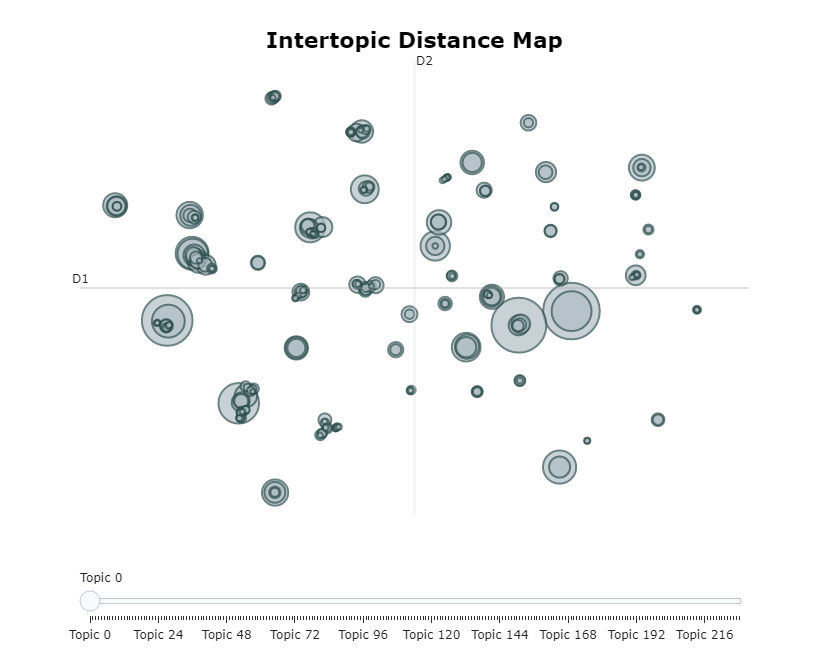

In [368]:
topic_model.visualize_topics()

In [108]:
print('Total number of topics: ', len(set(topic_model.topics_)))
print('Total number of outliers: ', topic_model.get_topic_freq(-1))
for i in range(10):
    print(f'size: {topic_model.get_topic_freq(i)} {[p[0] for p in topic_model.get_topic(i)][:5]}')

Total number of topics:  49
Total number of outliers:  26491
size: 5970 ['det', 'att', 'jag', 'som', 'är']
size: 4276 ['att', 'och', 'det', 'är', 'som']
size: 3551 ['att', 'det', 'är', 'som', 'har']
size: 3082 ['det', 'att', 'är', 'som', 'och']
size: 2565 ['att', 'det', 'är', 'och', 'som']
size: 2550 ['att', 'det', 'och', 'på', 'är']
size: 2247 ['att', 'som', 'det', 'och', 'vi']
size: 1973 ['att', 'och', 'det', 'som', 'är']
size: 1877 ['kvinnor', 'att', 'och', 'det', 'är']
size: 1869 ['att', 'det', 'och', 'är', 'för']


In [109]:
topic_model.find_topics('flykting')

([27, 21, 20, 18, 22],
 [0.49000613095397305,
  0.46570784014623207,
  0.44532578329169636,
  0.4343345757188351,
  0.41418658100939276])

## Plot document frequency of immigration related topics


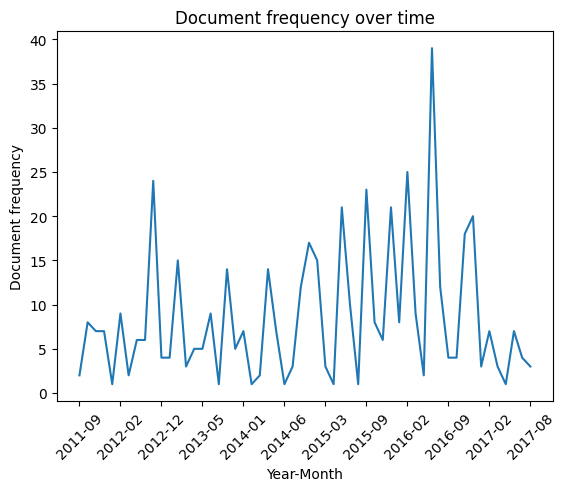

<Figure size 1200x600 with 0 Axes>

In [114]:
import matplotlib.pyplot as plt

immigration_related_topics = [21]

imig_df = pd.DataFrame({'topic': topics, 'text':docs, 'date': timestamps})

imig_df = imig_df.loc[imig_df.topic == immigration_related_topics[0]]
imig_df['year_month'] = imig_df['date'].dt.strftime('%Y-%m')
imig_df.drop(columns=['date'], inplace=True)

# Group the data by year and month
topics_by_year_month = imig_df.groupby('year_month')['topic'].count()
# To make it more readable on the x-axis
tick_locations = topics_by_year_month.index[::5]
tick_labels = topics_by_year_month.index[::5]

# Plot the rolling average as a line chart
plt.title('Document frequency over time')
plt.xlabel('Year-Month')
plt.ylabel('Document frequency')
plt.plot(topics_by_year_month)
plt.xticks(tick_locations, tick_labels, rotation=45)
plt.figure(figsize=(12,6))

plt.show()

# Export df
topics_by_year_month.to_csv(f'{CURRENT_EXPERIMENT}-df.csv')


## Plotting the frequency of immigration related words

In [115]:
immigration_related_words = []

for topic in immigration_related_topics:
    print(f'topic={topic} size={topic_model.get_topic_freq(topic)}')
    print([pair[0] for pair in topic_model.get_topic(topic)])
    immigration_related_words.extend([pair[0] for pair in topic_model.get_topic(topic)])
    print()

immigration_related_words = set(immigration_related_words)

print(immigration_related_words)

topic=21 size=479
['syrien', 'och', 'irak', 'att', 'för', 'är', 'som', 'vi', 'det', 'de']

{'vi', 'det', 'irak', 'de', 'som', 'och', 'är', 'för', 'att', 'syrien'}


In [116]:
immigration_related_words = ['syrien', 'irak']

print("Selected immigration related words:", immigration_related_words)
cv = topic_model.vectorizer_model # Extract the CounterVectorizer used in topic_model
X = cv.transform(docs) # Get the document-term matrix

Selected immigration related words: ['syrien', 'irak']


In [117]:
X.shape

(77326, 218732)

In [118]:
saliences = []
for i in tqdm(range(len(docs)), desc="Calculating frequency of words"):
    f = 0
    for word in immigration_related_words:
        f += X[i, cv.vocabulary_[word]]
    W = np.sum(X[i, :])
    saliences.append(f / W)


Calculating frequency of words: 100%|██████████████████████████████████████████| 77326/77326 [00:44<00:00, 1746.70it/s]


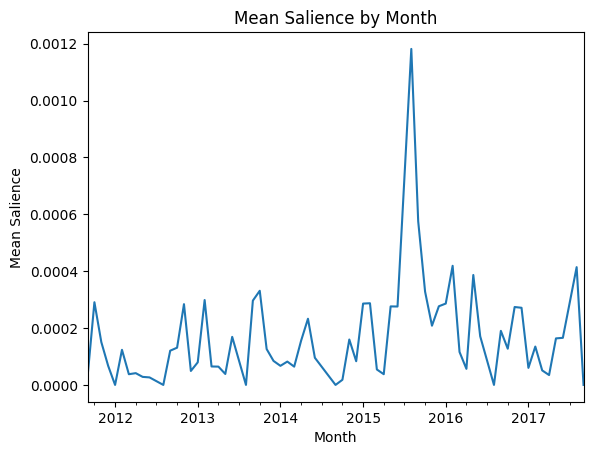

In [119]:
salience_df = pd.DataFrame({'salience':saliences, 'date':timestamps})
salience_df['year_month'] = salience_df['date'].dt.strftime('%Y-%m')
salience_df['year_month'] = pd.to_datetime(salience_df['year_month'])

salience_df.drop(columns=['date'], inplace=True)
df_monthly = salience_df.groupby(pd.Grouper(key='year_month', freq='M'))['salience'].mean()
df_monthly = df_monthly.interpolate()
df_monthly.plot(kind='line')
plt.title('Mean Salience by Month')
plt.xlabel('Month')
plt.ylabel('Mean Salience')
plt.show()

df_monthly.to_csv(f'{CURRENT_EXPERIMENT}-mean-salience.csv')